In [8]:
# from matplotlib.animation import FuncAnimation
# from animation import Anim
# from matplotlib.interactivePlot import InteractivePlot as Plot
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import h5py
import glob
import os

In [9]:
# nx =fs_IS[0]['Domain'].attrs['nx']
# NN = nx //2 
# print(NN)

In [10]:
# fs_IS[0]['Domain'].attrs.keys()

In [11]:
def getFourierTrans(intPlot, u):
    """
    Returns the 1D discrete fourier transform of the variable u along the x-direction
    ready for the power spectrum method.
    Parameters
    ----------
    intPlot : object
        interactivePlot object containing all the simulation data, normally the final instance
    u : ndarray
        Two dimensional array of the variable we want the power spectrum of
    Returns
    -------
    uhat : array (N,)
        Fourier transform of u
    """
    nx, ny = intPlot['Domain'].attrs['nx'][0], intPlot['Domain'].attrs['ny'][0]
    NN = nx // 2
    uhat = np.zeros((NN, ny), dtype=np.complex_)

    for k in range(NN):
        for y in range(ny):
            # Sum over all x adding to uhat
            for i in range(nx):
                uhat[k, y] += u[i, y] * np.exp(-(2*np.pi*1j*k*i)/nx)

    return uhat / nx

In [12]:
# getFourierTrans(fs_IS[0], fs_IS[0]['Primitive/v1'])

In [13]:
def getPowerSpectrumSq(intPlot, u):
    """
    Returns the integrated power spectrum of the variable u, up to the Nyquist frequency = nx/2
    Parameters
    ----------
    intPlot : object
        interactivePlot object containing all the simulation data, normally the final instance
    u : ndarray
        Two dimensional array of the variable we want the power spectrum of
    """
    NN = intPlot['Domain'].attrs['nx'][0] // 2
    dy = intPlot['Domain'].attrs['dy'][0]
    uhat = getFourierTrans(intPlot, u)
    P = np.zeros(NN)

    for k in range(NN):
        for j in range(intPlot['Domain'].attrs['ny'][0]):
            P[k] += (np.absolute(uhat[k, j])**2) * dy

    P = P / np.sum(P)
    return P

In [14]:
def GetKESF(frame):
    """
    Retrieves and computes the kinetic energy density for each frame in a single fluid animation.
    Parameters
    ----------
    anim : object
        animation class containing all user def variables
    frame : Array
        Frame from the animation class containing all user def variables at the time we want
    """
    vx = frame['Primitive/v1'][:]
    vy = frame['Primitive/v2'][:]
    rho = frame['Primitive/rho']
    vsq = vx**2 + vy**2
    W = 1 / np.sqrt(1 - vsq)
    KE = rho * W * (W-1) ## this expression ??

    return KE

In [15]:
def trim(a,b,listt):
    return listt[a:b]

In [16]:
# GetKESF(fs_IS[0])

In [17]:
fs_IS_Id = []
fs_IS_Sh = []

fs_ISCE_Id = []
fs_ISCE_Sh = []

fs_BDNK_Id = []
fs_BDNK_Sh = []

n_files = 11
for n in range(n_files):
#     fs_IS.append(h5py.File(f'IS/KH/Ideal/cfl04/dp_1200x1200x0_{n}.hdf5', 'r'))
#     fs_IS.append(h5py.File(f'IS/KH/Ideal/cfl04/dp_200x200x0_{n}.hdf5', 'r'))
#     fs_IS_Id.append(h5py.File(f'IS/KH/Ideal/dp_800x800x0_{n}.hdf5', 'r'))
#     fs_IS_Sh.append(h5py.File(f'IS/KH/Shear/tau5em1eta5em3/dp_200x200x0_{n}.hdf5', 'r'))
#     fs_IS_Sh.append(h5py.File(f'IS/KH/Shear/dp_800x800x0_{n}.hdf5', 'r'))
   
    fs_ISCE_Id.append(h5py.File(f'ISCE/KH/Ideal/dp_800x800x0_{n}.hdf5', 'r'))
#     fs_ISCE_Sh.append(h5py.File(f'ISCE/KH/Shear/tau5em2eta5em3/dp_200x200x0_{n}.hdf5', 'r'))
    fs_ISCE_Sh.append(h5py.File(f'ISCE/KH/Shear/dp_800x800x0_{n}.hdf5', 'r'))

#     fs_BDNK_Id.append(h5py.File(f'BDNK/KH/Ideal/dp_800x800x0_{n}.hdf5', 'r'))
#     fs_BDNK_Sh.append(h5py.File(f'BDNK/KH/eta0_5em4/dp_200x200x0_{n}.hdf5', 'r'))

fss = [fs_IS_Id, fs_IS_Sh, fs_ISCE_Id, fs_ISCE_Sh, fs_BDNK_Id, fs_BDNK_Sh]
labels = ['IS Ideal','IS Shear','ISCE Ideal','ISCE Shear','BDNK Ideal','BDNK Shear']
names = ['IS_Id','IS_Sh','ISCE_Id','ISCE_Sh','BDNK_Id','BDNK_Sh']
fss, labels, names = trim(2,4,fss), trim(2,4,labels), trim(2,4,names)
print(fss,labels,names)

[[<HDF5 file "dp_800x800x0_0.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_1.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_2.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_3.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_4.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_5.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_6.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_7.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_8.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_9.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_10.hdf5" (mode r)>], [<HDF5 file "dp_800x800x0_0.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_1.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_2.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_3.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_4.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_5.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_6.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_7.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_8.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_9.hdf5" (mode r)>, <HDF5 file "dp_800x800x0_10.hdf5" (mode r)>]] ['ISCE Ideal', 'ISCE Shea

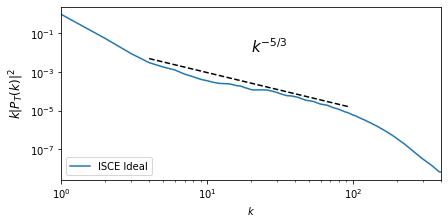

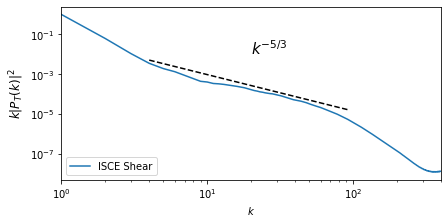

In [79]:
ISCESpecIdeal = 0
ISCESpecShear = 0
for fs, label, name in zip(fss, labels, names):
    Ideal = fs[4]
    #idealT = Ideal.t.index(min(Ideal.t, key=lambda x : abs(x-3.0)))
    Nideal = fs[-1]['Domain'].attrs['nx'][0] // 2
    KESpecIdeal = getPowerSpectrumSq(Ideal, GetKESF(Ideal))
    if(name == 'ISCE_Id'):
        ISCESpecIdeal = KESpecIdeal
    if(name == 'ISCE_Sh'):
        ISCESpecShear = KESpecIdeal
        
    ### Model Power Spectrum

    fig, axs = plt.subplots(1, 1, sharex=True)
    fig.set_size_inches(6,3)
    fig.tight_layout()

    # Kinetic energy density power
    axs.loglog(np.arange(1, Nideal+1), np.arange(1, Nideal+1)*KESpecIdeal, label=label)# label=r'$IS \ Ideal$')
    #     axs.loglog(np.arange(1, Nresistive+1), np.arange(1, Nresistive+1)*KESpecResistive, label=r'$Single \ Fluid \ Resistive$')
    #     axs.loglog(np.arange(1, NtwoFluid+1), np.arange(1, NtwoFluid+1)*KESpecTwoFluid, label=r'$Two \ Fluid \ Resistive$')
    axs.set_ylabel(r"$k|P_{T}(k)|^2$", {'fontsize':'large'})
    axs.set_xlabel(r'$k$')
    # axs.loglog([4, 94.868], [5*10**-3, 5*10**(-3 - 1.5*5/3)], 'k--')
    axs.loglog([4, 94], [5*10**-3, 5*10**(-3 - 1.5*5/3)], 'k--')
    axs.annotate(r'$k^{-5/3}$', xy=(20, 0.01), fontsize=15)
    axs.set_xlim([1, Nideal])
    axs.legend(loc='lower left')


    # plt.savefig('ConfirmationReportPlots/KH/KolmoEnergyIdeal.eps', format='eps', dpi=1200, bbox_inches='tight')
#     plt.savefig('ConfirmationReportPlots/KH/KolmoEnergy_'+name+'.pdf', dpi=1200, bbox_inches='tight')

    plt.show()

In [80]:
KESpecShear2 = ISCESpecShear
KESpecIdeal2 = ISCESpecIdeal

[  5.           6.93877551   8.87755102  10.81632653  12.75510204
  14.69387755  16.63265306  18.57142857  20.51020408  22.44897959
  24.3877551   26.32653061  28.26530612  30.20408163  32.14285714
  34.08163265  36.02040816  37.95918367  39.89795918  41.83673469
  43.7755102   45.71428571  47.65306122  49.59183673  51.53061224
  53.46938776  55.40816327  57.34693878  59.28571429  61.2244898
  63.16326531  65.10204082  67.04081633  68.97959184  70.91836735
  72.85714286  74.79591837  76.73469388  78.67346939  80.6122449
  82.55102041  84.48979592  86.42857143  88.36734694  90.30612245
  92.24489796  94.18367347  96.12244898  98.06122449 100.        ]


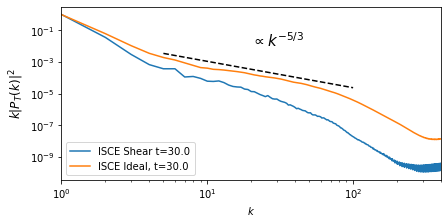

In [114]:
# KESpecShear = ISCESpecShear
# KESpecIdeal = ISCESpecIdeal

fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(6,3)
fig.tight_layout()

# Kinetic energy density power
# axs.loglog(np.arange(1, Nideal+1), np.arange(1, Nideal+1)*KESpecShear2, label=labels[1]+' t=12.0')# label=r'$IS \ Ideal$')
axs.loglog(np.arange(1, Nideal+1), np.arange(1, Nideal+1)*KESpecShear, label=labels[1]+' t=30.0')# label=r'$IS \ Ideal$')
# axs.loglog(np.arange(1, Nideal+1), np.arange(1, Nideal+1)*KESpecIdeal2, label=labels[0]+', t=12.0')# label=r'$IS \ Ideal$')
axs.loglog(np.arange(1, Nideal+1), np.arange(1, Nideal+1)*KESpecIdeal, label=labels[0]+', t=30.0')# label=r'$IS \ Ideal$')

axs.set_ylabel(r"$k|P_{T}(k)|^2$", {'fontsize':'large'})
axs.set_xlabel(r'$k$')
ks = np.linspace(5,100)
print(ks)
axs.loglog(ks,(5*10**-2)*ks**(-5/3), 'k--')
# axs.loglog([4, 94.868], [3*10**-3, (3*10**-3)*((94.868/4)*-5/3)], 'k--')
# axs.loglog([4, 94], [8*10**-3, 8*10**(-3 - 1.5*5/3)], 'k--')
# axs.loglog([5, 100], [2*10**-3, 2*10**(-3 - (5/3))], 'k--')
axs.annotate(r'$\propto k^{-5/3}$', xy=(20, 0.01), fontsize=15)
axs.set_xlim([1, Nideal])
axs.legend(loc='lower left')


# plt.savefig('ConfirmationReportPlots/KH/KolmoEnergyIdeal.eps', format='eps', dpi=1200, bbox_inches='tight')
# plt.savefig('ConfirmationReportPlots/KH/KolmoEnergyISCE_Sh_53_t12vst30'+name+'.pdf', dpi=1200, bbox_inches='tight')
plt.savefig('ConfirmationReportPlots/KH/KolmoEnergyISCE_IdvsSh_53_t12'+name+'.pdf', dpi=1200, bbox_inches='tight')
plt.savefig('ConfirmationReportPlots/KH/KolmoEnergyISCE_IdvsSh_53_t30'+name+'.pdf', dpi=1200, bbox_inches='tight')

plt.show()

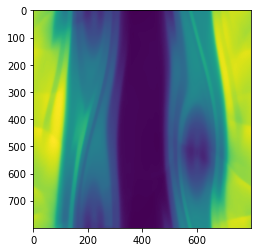

endtime: [30.]
Dissipation strengths: zeta 1e-15, kappa: 1e-15,  eta: 1e-15, relaxation time 0.5, timestep 0.00035355339059327376
endtime: [30.]
Dissipation strengths: zeta 1e-15, kappa: 1e-15,  eta: 0.0001, relaxation time 0.5, timestep 0.00035355339059327376


In [21]:
plt.imshow(fss[1][-1]['Primitive/n'])
plt.show()
for fs in fss:
    print(f"endtime: {fs[-1].attrs['t']}")
#     print(f"Domain size: {fs[-1]['Domain/x']}")
    zeta = fs[0]['Optional'].attrs['zeta'][0]
    kappa = fs[0]['Optional'].attrs['kappa'][0]
    eta = fs[0]['Optional'].attrs['eta'][0]

    tau_Pi = fs[0]['Optional'].attrs['tau_Pi'][0]
    tau_q = fs[0]['Optional'].attrs['tau_q'][0]
    tau_pi = fs[0]['Optional'].attrs['tau_pi'][0]

    print(f"Dissipation strengths: zeta {zeta}, "
          f"kappa: {kappa}, ", f"eta: {eta}, "
      f"relaxation time {tau_pi}, "
      f"timestep {fs[0]['Domain'].attrs['dt'][0]}")

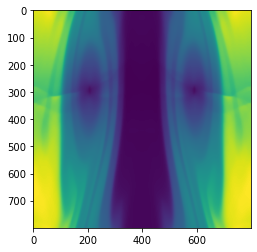

In [22]:
plt.imshow(fss[0][-1]['Primitive/n'])
plt.show()